In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom

from tqdm import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
from scipy.fft import fft2, fftshift
from skimage.filters import sobel
from skimage.metrics import structural_similarity

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11

In [15]:
# -------- PATHS --------
ROOT_SPLIT = "../../dataset/split_dataset"
BASELINE_ROOT = "../../dataset/baseline"
HYF_ROOT = "../../dataset/hyfusion_v2"

MANIFEST_HYF = os.path.join(HYF_ROOT, "manifest", "hyfusion_manifest.csv")
SITE_DHI_CSV = os.path.join(HYF_ROOT, "manifest", "site_dhi_components.csv")

df_hyf = pd.read_csv(MANIFEST_HYF)
df_site = pd.read_csv(SITE_DHI_CSV)

print("HyFusion manifest:", df_hyf.shape)
print("Site DHI table:", df_site.shape)


HyFusion manifest: (20, 18)
Site DHI table: (1, 8)


In [16]:
def load_dicom_ie(path):
    ds = pydicom.dcmread(path)
    raw = apply_voi_lut(ds.pixel_array, ds)
    img = raw.astype(np.float32)
    if getattr(ds, "PhotometricInterpretation", "") == "MONOCHROME1":
        img = img.max() - img
    img = (img - img.min()) / (img.max() - img.min() + 1e-12)
    return img

def load_npy(path):
    return np.load(path).astype(np.float32)

def foreground_mask(img, thr=0.05):
    return img > thr

def compute_cnr(sig, ref, mask):
    s = sig[mask]
    r = ref[mask]
    return (s.mean() - r.mean()) / (r.std() + 1e-9)


In [17]:
# Pick representative samples
samples = (
    df_hyf
    .sort_values(["status", "alpha_final"])
    .groupby("site")
    .head(10)
    .sample(3, random_state=42)
)

samples[["split", "label", "site", "status", "alpha_final"]]


,split,label,site,status,alpha_final
8,train,NonTB,RS Paru dr. Ario Wirawan,ROLLBACK,0.252709
0,train,TB,RS Paru dr. Ario Wirawan,ROLLBACK,0.202709
5,train,NonTB,RS Paru dr. Ario Wirawan,ROLLBACK,0.252709


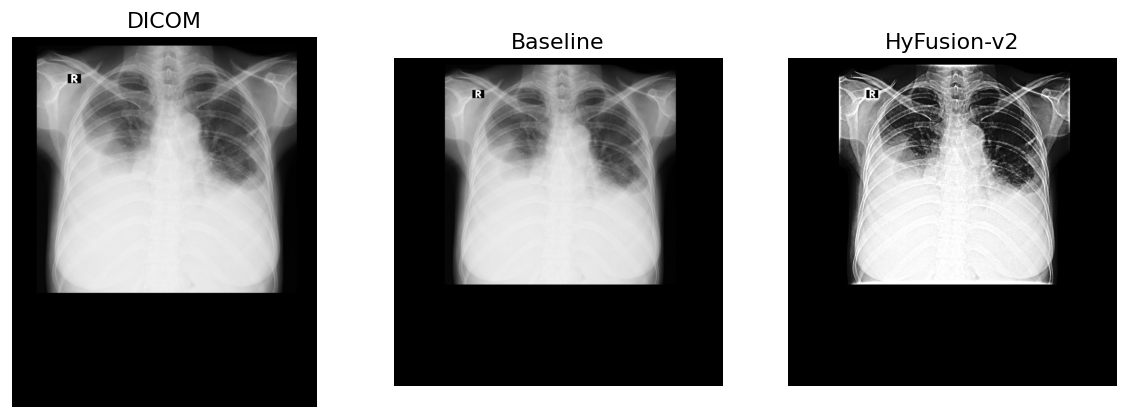

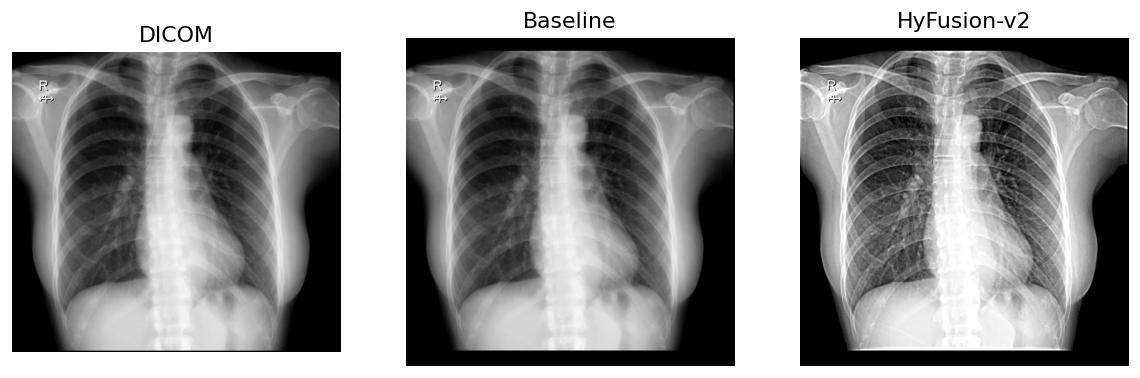

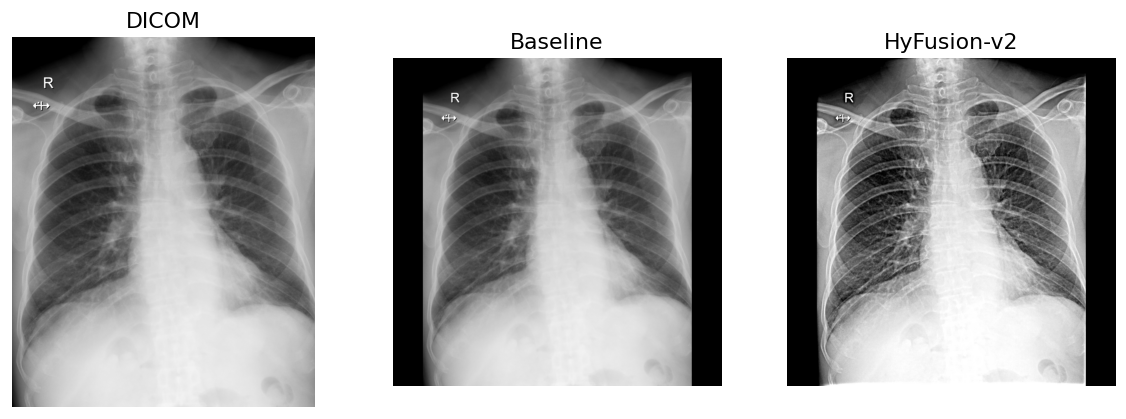

In [ ]:
for _, row in samples.iterrows():
        # --- LOAD DICOM ---
    dcm = load_dicom_ie(row["src_dicom"])

    row_id = row.name   
    base = np.load(os.path.join(BASELINE_ROOT, "NPY", f"X_{row['split']}.npy"))[row_id,:,:,0]
    hyf  = np.load(os.path.join(HYF_ROOT, "NPY", f"X_{row['split']}.npy"))[row_id,:,:,0]

    # --- PLOT ---
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(dcm, cmap="gray"); axs[0].set_title("DICOM")
    axs[1].imshow(base, cmap="gray");    axs[1].set_title("Baseline")
    axs[2].imshow(hyf, cmap="gray");     axs[2].set_title("HyFusion-v2")
    for a in axs: a.axis("off")
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.815511..8.459507].


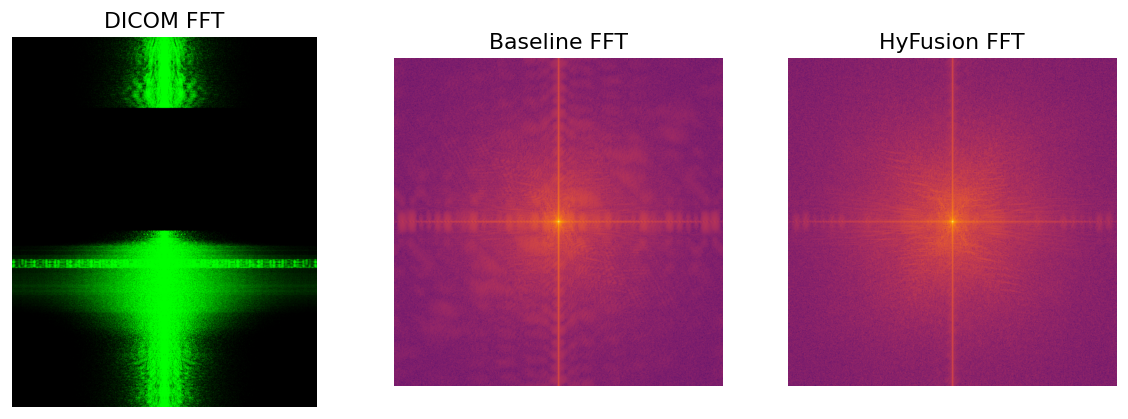

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.815511..8.164544].


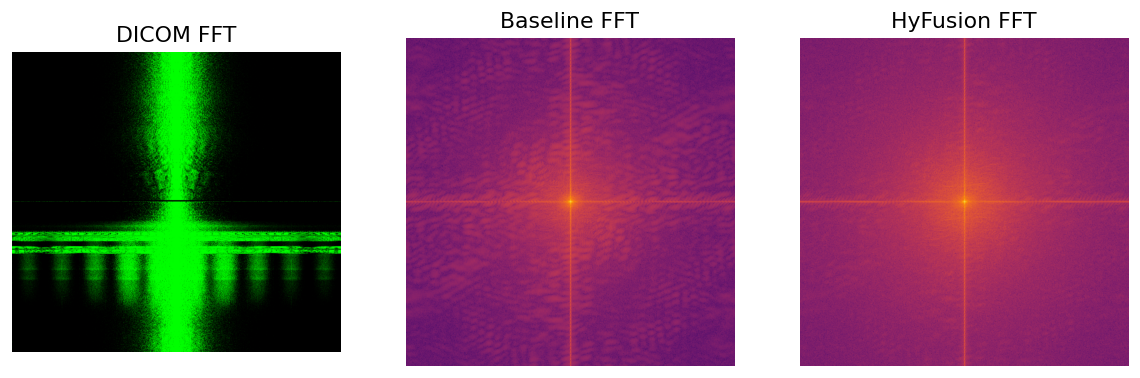

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.815511..8.64975].


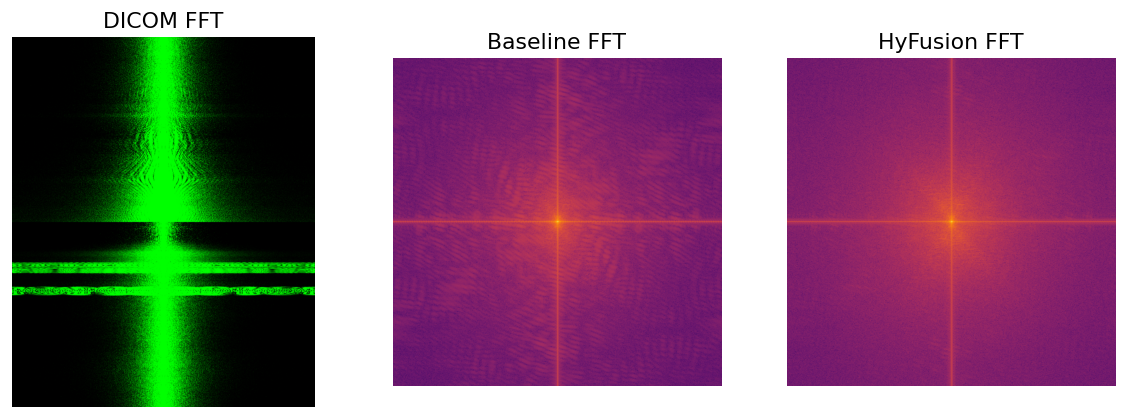

In [ ]:
def power_spectrum(img):
    F = fftshift(fft2(img))
    return np.log(np.abs(F) + 1e-6)

for _, row in samples.iterrows():
    dcm = load_dicom_ie(row["src"])
    split = row["split"]
    idx = row.name

    base = np.load(os.path.join(BASELINE_ROOT,"NPY",f"X_{split}.npy"))[idx,:,:,0]
    hyf  = np.load(os.path.join(HYF_ROOT,"NPY",f"X_{split}.npy"))[idx,:,:,0]

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(power_spectrum(dcm), cmap="inferno"); axs[0].set_title("DICOM FFT")
    axs[1].imshow(power_spectrum(base), cmap="inferno"); axs[1].set_title("Baseline FFT")
    axs[2].imshow(power_spectrum(hyf), cmap="inferno"); axs[2].set_title("HyFusion FFT")
    for a in axs: a.axis("off")
    plt.show()


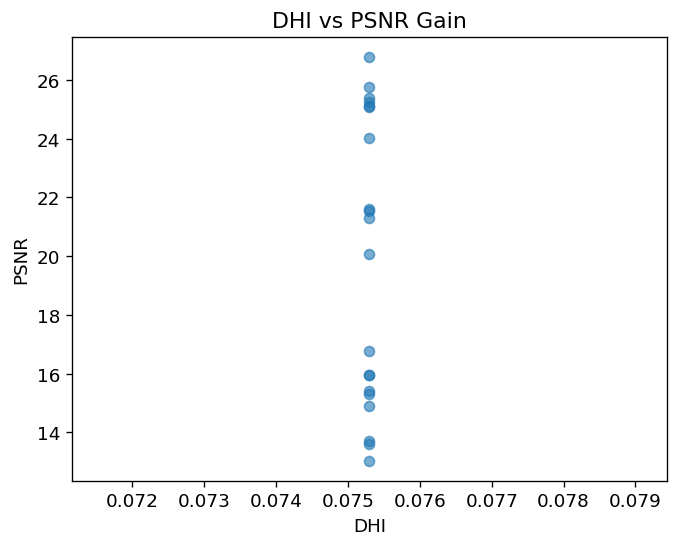

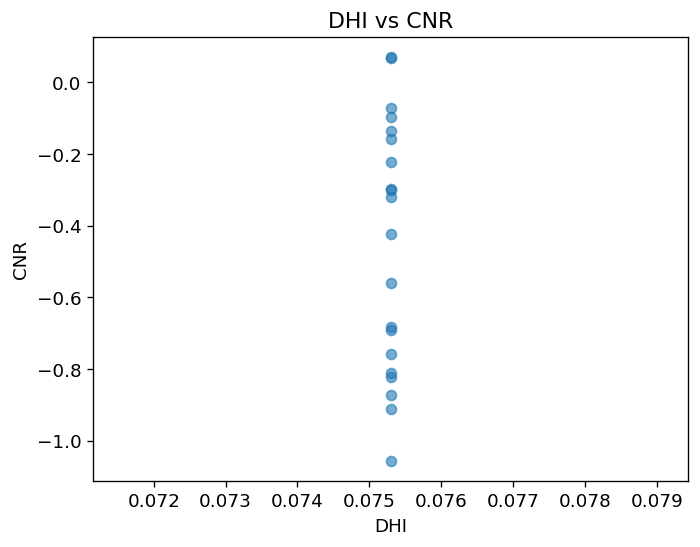

In [ ]:
df_merge = df_hyf.merge(df_site, on="site")

plt.scatter(df_merge["DHI"], df_merge["psnr"], alpha=0.6)
plt.xlabel("DHI")
plt.ylabel("PSNR")
plt.title("DHI vs PSNR Gain")
plt.show()

plt.scatter(df_merge["DHI"], df_merge["cnr"], alpha=0.6)
plt.xlabel("DHI")
plt.ylabel("CNR")
plt.title("DHI vs CNR")
plt.show()


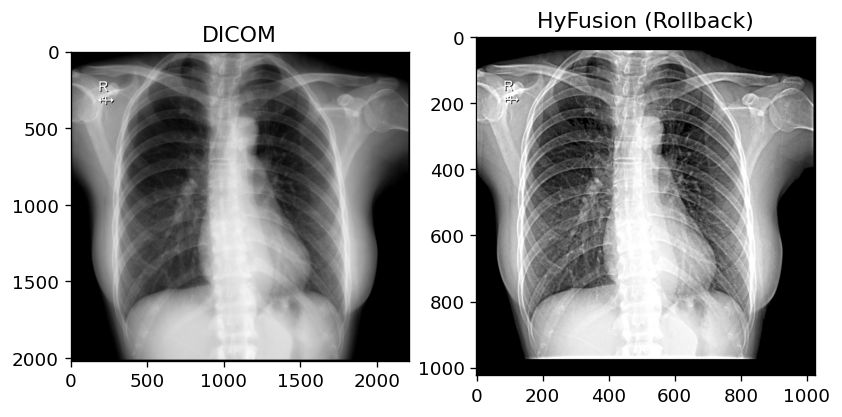

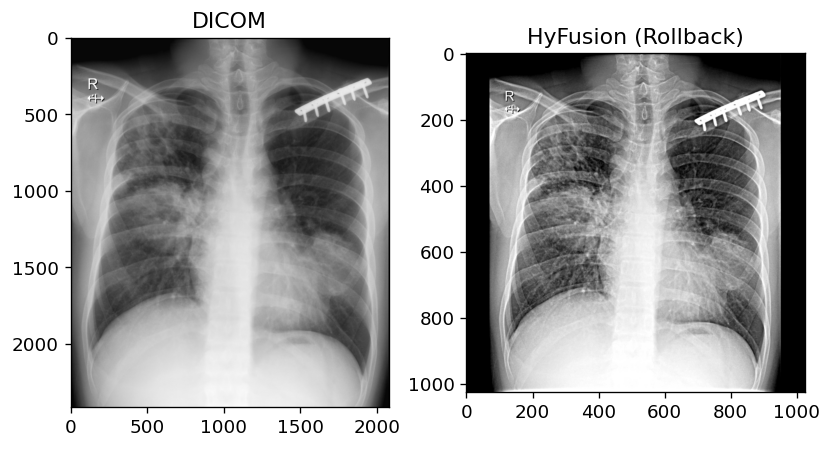

In [ ]:
fails = df_hyf[df_hyf["status"] != "OK"].head(2)

for _, row in fails.iterrows():
    dcm = load_dicom_ie(row["src"])
    split = row["split"]
    idx = row.name
    hyf  = np.load(os.path.join(HYF_ROOT,"NPY",f"X_{split}.npy"))[idx,:,:,0]

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(dcm,cmap="gray"); plt.title("DICOM")
    plt.subplot(1,2,2); plt.imshow(hyf,cmap="gray"); plt.title("HyFusion (Rollback)")
    plt.show()
